In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from joblib import Parallel, delayed
from functools import partial
from scipy.stats import median_abs_deviation
import anndata as ad
import scanpy as sc
import seaborn as sns

import os
os.chdir('/laune_zfs/scratch/peter/f_active/paper_23/') # laune

In [4]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [5]:
meta = pd.read_csv('input/02_stereoseq_qc/metadata/sample_metadata_batch1_batch2.csv')
meta = meta.loc[meta['sample_id'] != 'D01066E3']
meta = meta.loc[meta['sample_id'] != 'C01339B2']
meta['group_n'] = (meta.groupby(['age', 'genotype']).cumcount()+1).astype('str')
meta['sample_name'] = meta['age'] + '_' + meta['genotype'] + '_' + meta['group_n']
meta.sort_values('sample_name', inplace=True)
meta

,sample_id,mouse,age,genotype,batch,group_n,sample_name
0,D01066F5,REL119.4D,OLD,OVX,batch2,1,OLD_OVX_1
1,FP200000578TR_C5,REL120.1B,OLD,OVX,batch1,2,OLD_OVX_2
9,FP200000542BR_A1,REL120.1A,OLD,OVX,batch1,3,OLD_OVX_3
15,D01066F4,REL117.2C,OLD,OVX,batch2,4,OLD_OVX_4
18,D01066D6,REL119.1H,OLD,OVX,batch2,5,OLD_OVX_5
2,FP200000542BR_F4,REL121.1B,OLD,WT,batch1,1,OLD_WT_1
3,SS200000953BR_C5,REL116.3C,OLD,WT,batch2,2,OLD_WT_2
6,FP200000578TR_C3,REL121.1A,OLD,WT,batch1,3,OLD_WT_3
10,SS200000795TL_F5,REL116.3D,OLD,WT,batch2,4,OLD_WT_4
13,SS200000953BR_C6,REL124.3B,OLD,WT,batch2,5,OLD_WT_5


In [6]:
sample_to_sample_name = dict(zip(meta['sample_id'], meta['sample_name']))
adatas = {x.split('/')[-1].split('.h5ad')[0]:x for x in glob.glob('input/01_stereoseq_preprocessing/adata/*.h5ad')}
adatas = {sample_to_sample_name[k]:v for k,v in adatas.items() if k in meta['sample_id'].to_list()}
adatas = dict(sorted(adatas.items()))
adatas = {k:ad.read_h5ad(v) for k,v in adatas.items()}
data = pd.concat({k:v.obs for k,v in adatas.items()}, names = ['sample_id', 'cell_n']).reset_index()
data

,sample_id,cell_n,area
0,OLD_OVX_1,1,188.0
1,OLD_OVX_1,2,366.0
2,OLD_OVX_1,3,183.0
3,OLD_OVX_1,4,322.0
4,OLD_OVX_1,5,276.0
...,...,...,...
497761,YOUNG_WT_4,36743,473.0
497762,YOUNG_WT_4,36744,481.0
497763,YOUNG_WT_4,36745,183.0
497764,YOUNG_WT_4,36746,343.0


In [4]:
sample_to_sample_name = dict(zip(meta['sample_id'], meta['sample_name']))
adatas = {x.split('/')[-1].split('.h5ad')[0]:x for x in glob.glob('input/01_stereoseq_preprocessing/adata/*.h5ad')}
adatas = {sample_to_sample_name[k]:v for k,v in adatas.items() if k in meta['sample_id'].to_list()}
adatas = dict(sorted(adatas.items()))
adatas = {k:ad.read_h5ad(v) for k,v in adatas.items()}
for k,v in adatas.items():
    v.var_names_make_unique()
    sc.pp.filter_genes(v, min_cells=20)
    # mitochondrial genes
    v.var["mt"] = v.var_names.str.startswith("mt-")
    # ribosomal genes
    v.var["ribo"] = v.var_names.str.startswith(("Rp"))
    # hemoglobin genes
    v.var["hb"] = v.var_names.str.contains(("^Hb[^(P)]"))
    sc.pp.calculate_qc_metrics(v, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    sc.pp.filter_cells(v, min_genes=200)
    mad = 4
    v.obs["outlier"] = (is_outlier(v, "log1p_total_counts", mad)
    | is_outlier(v, "log1p_n_genes_by_counts", mad)
    | is_outlier(v, "pct_counts_in_top_20_genes", mad)
    | is_outlier(v, "pct_counts_mt", mad))
    # print(k + ' outliers: ' + str(v.obs.outlier.value_counts()))
    v = v[(~v.obs.outlier)]
    v.obs_names = [k + '_' + str(x+1) for x in range(v.shape[0])]
    adatas[k] = v.copy()

In [5]:
data = pd.concat({k:v.obs for k,v in adatas.items()}, names = ['sample_id', 'cell_n']).reset_index()
data

,sample_id,cell_n,area,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,outlier
0,OLD_OVX_1,OLD_OVX_1_1,324.0,207,5.337538,435,6.077642,32.643678,0,0.000000,0.000000,3,1.386294,0.689655,0,0.000000,0.000000,207,False
1,OLD_OVX_1,OLD_OVX_1_2,362.0,248,5.517453,454,6.120297,28.414097,3,1.386294,0.660793,4,1.609438,0.881057,0,0.000000,0.000000,248,False
2,OLD_OVX_1,OLD_OVX_1_3,440.0,264,5.579730,546,6.304449,28.205128,0,0.000000,0.000000,5,1.791759,0.915751,0,0.000000,0.000000,264,False
3,OLD_OVX_1,OLD_OVX_1_4,669.0,400,5.993961,832,6.725034,26.442308,0,0.000000,0.000000,15,2.772589,1.802885,0,0.000000,0.000000,400,False
4,OLD_OVX_1,OLD_OVX_1_5,414.0,244,5.501258,529,6.272877,29.678639,1,0.693147,0.189036,9,2.302585,1.701323,0,0.000000,0.000000,244,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415397,YOUNG_WT_4,YOUNG_WT_4_29718,278.0,375,5.929589,457,6.126869,13.785558,0,0.000000,0.000000,2,1.098612,0.437637,0,0.000000,0.000000,375,False
415398,YOUNG_WT_4,YOUNG_WT_4_29719,219.0,237,5.472271,278,5.631212,16.187050,0,0.000000,0.000000,1,0.693147,0.359712,0,0.000000,0.000000,237,False
415399,YOUNG_WT_4,YOUNG_WT_4_29720,473.0,959,6.866933,1345,7.204893,10.111524,3,1.386294,0.223048,15,2.772589,1.115242,2,1.098612,0.148699,959,False
415400,YOUNG_WT_4,YOUNG_WT_4_29721,183.0,203,5.318120,222,5.407172,17.567568,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,203,False


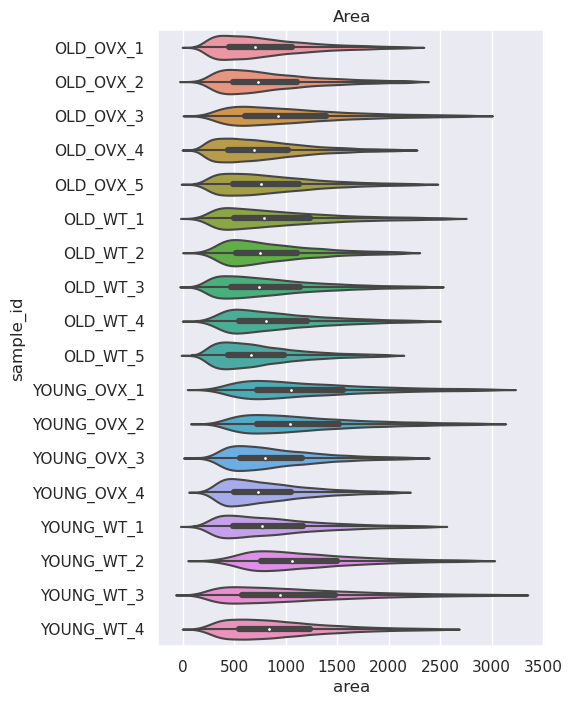

In [6]:
sns.set(rc={'figure.figsize':(5,8)})
p = sns.violinplot(data, x = "area", y = 'sample_id').set_title('Area')

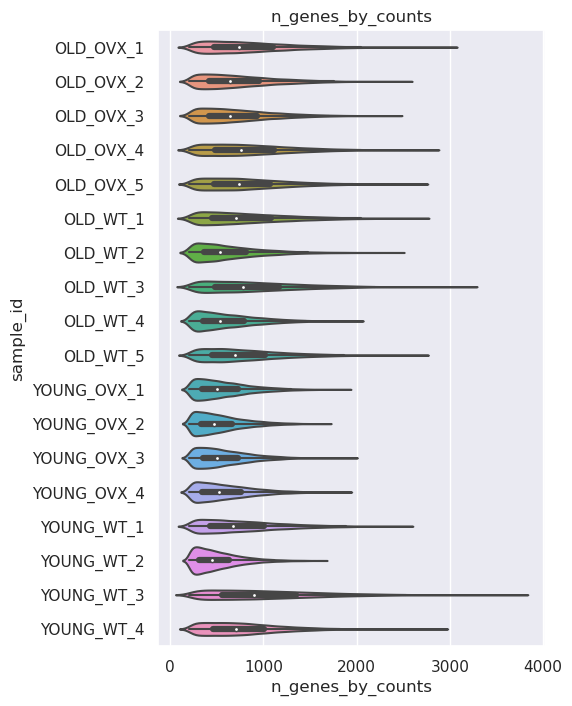

In [7]:
sns.set(rc={'figure.figsize':(5,8)})
p = sns.violinplot(data, x = "n_genes_by_counts", y = 'sample_id').set_title('n_genes_by_counts')

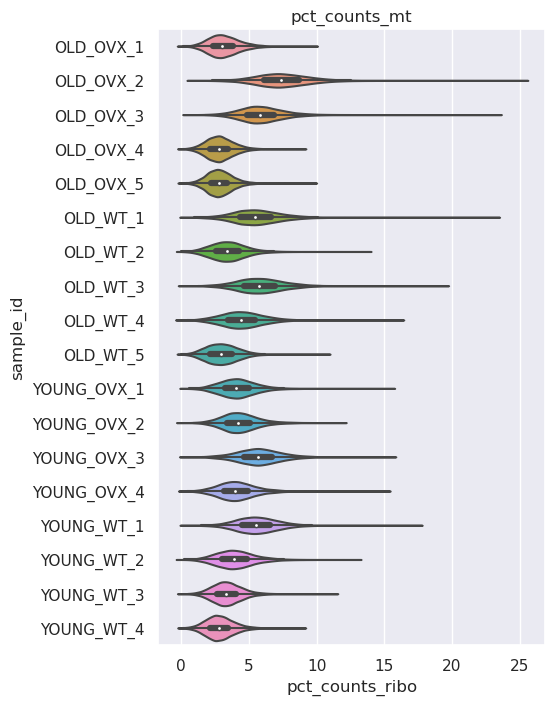

In [8]:
sns.set(rc={'figure.figsize':(5,8)})
p = sns.violinplot(data, x = "pct_counts_ribo", y = 'sample_id').set_title('pct_counts_mt')

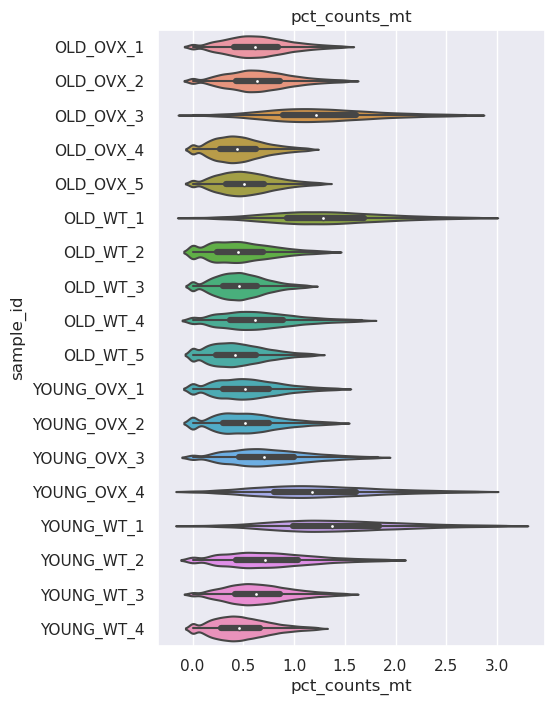

In [9]:
sns.set(rc={'figure.figsize':(5,8)})
p = sns.violinplot(data, x = "pct_counts_mt", y = 'sample_id').set_title('pct_counts_mt')

In [10]:
names = list(adatas.keys())
adata = adatas[names[0]]
df = pd.DataFrame(adata.obsm['spatial'].astype('int'), columns = ['x', 'y'])
adata.obs['x'] = df['x'].to_list()
adata.obs['y'] = df['y'].to_list()
# del adata.uns
del adata.obsm

adata.obs['sample_name'] = names[0]

for name in names[1:]:
    print(name)
    # del adatas[name].uns
    df = pd.DataFrame(adatas[name].obsm['spatial'].astype('int'), columns = ['x', 'y'])
    adatas[name].obs['x'] = df['x'].to_list()
    adatas[name].obs['y'] = df['y'].to_list()
    del adatas[name].obsm
    adatas[name].obs['sample_name'] = name
    adata = ad.concat([adata, adatas[name]])
adata.obs = adata.obs.join(meta.set_index('sample_name'), on = 'sample_name')

OLD_OVX_2
OLD_OVX_3
OLD_OVX_4
OLD_OVX_5
OLD_WT_1
OLD_WT_2
OLD_WT_3
OLD_WT_4
OLD_WT_5
YOUNG_OVX_1
YOUNG_OVX_2
YOUNG_OVX_3
YOUNG_OVX_4
YOUNG_WT_1
YOUNG_WT_2
YOUNG_WT_3
YOUNG_WT_4


In [11]:
adata

AnnData object with n_obs × n_vars = 415402 × 14494
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n'

In [12]:
output_path = 'input/02_stereoseq_qc/adata'
if not os.path.exists(output_path):
        print("Output path does not exist. Creating...")
        os.makedirs(output_path)
adata.write_h5ad('input/02_stereoseq_qc/adata/adata.h5ad')